# Phishing Email Detection with RoBERTa: Overview & Workflow

This notebook provides a step-by-step guide to phishing email detection using the RoBERTa model.

## Workflow Summary

1. **Library Imports and Environment Setup**  
   - Import essential Python libraries such as pandas, numpy, torch, scikit-learn, matplotlib, transformers, and tqdm.
   - Fix random seeds for random, numpy, and torch to ensure full reproducibility of experiments.

2. **Data Loading and Preprocessing**  
   - Load the phishing email dataset.
   - Remove unnecessary columns, handle missing and duplicate entries.
   - Convert data types and encode labels ("Safe Email" as 1, "Phishing Email" as 0).

3. **Data Splitting**  
   - Split the preprocessed data into training, validation, and test sets using stratified sampling to maintain class balance.

4. **Tokenization and Dataset Preparation**  
   - Tokenize email texts using the RoBERTa tokenizer.
   - Define a custom PyTorch Dataset class to prepare the data for model input.

5. **DataLoader Construction**  
   - Create DataLoaders for training, validation, and test datasets to enable efficient batch processing.

6. **Model Initialization and Training Setup**  
   - Load the RobertaForSequenceClassification model, set up the device (CPU/MPS), optimizer (AdamW), and learning rate scheduler.

7. **Model Training and Validation**  
   - Train the model on the training set and monitor performance on the validation set.
   - Record training loss and validation accuracy for each epoch, and apply Early Stopping to save the best model.

8. **Model Evaluation**  
   - Evaluate the model on the test set.
   - Calculate and visualize various metrics such as accuracy, F1-score, classification report, and confusion matrix.

--- 

# RoBERTa 기반 피싱 이메일 탐지: 개요 및 워크플로우

이 노트북은 RoBERTa 기반 피싱 이메일 탐지의 전체 실습 과정을 단계별로 안내합니다.

## 전체 워크플로우 요약

1. **라이브러리 임포트 및 환경 설정**  
   - pandas, numpy, torch, scikit-learn, matplotlib, transformers, tqdm 등 필요한 파이썬 라이브러리를 임포트합니다.
   - random, numpy, torch의 시드를 고정하여 실험의 재현성을 보장합니다.

2. **데이터 불러오기 및 전처리**  
   - 피싱 이메일 데이터셋을 불러옵니다.
   - 불필요한 열을 제거하고, 결측치와 중복 데이터를 처리합니다.
   - 데이터 타입을 변환하고, 레이블(정상/피싱)을 인코딩합니다.  
     (이 노트북에서는 "Safe Email"을 1, "Phishing Email"을 0으로 인코딩합니다.)

3. **데이터 분할**  
   - 전처리된 데이터를 학습, 검증, 테스트 세트로 stratified sampling(계층적 샘플링)을 통해 분할하여 클래스 불균형을 방지합니다.

4. **토크나이징 및 데이터셋 준비**  
   - RoBERTa 토크나이저를 사용해 이메일 텍스트를 토크나이즈합니다.
   - PyTorch Dataset 클래스를 정의하여 모델 입력에 맞는 데이터셋을 준비합니다.

5. **DataLoader 구성**  
   - 학습, 검증, 테스트 데이터셋에 대해 DataLoader를 생성하여 배치 단위로 데이터를 효율적으로 처리할 수 있도록 합니다.

6. **모델 초기화 및 학습 환경 설정**  
   - RobertaForSequenceClassification 모델을 불러오고, 디바이스(CPU/MPS), 옵티마이저(AdamW), 러닝레이트 스케줄러 등을 설정합니다.

7. **모델 학습 및 검증**  
   - 학습 데이터로 모델을 학습시키고, 검증 데이터로 성능을 모니터링합니다.
   - 에폭별로 학습 손실과 검증 정확도를 기록하며, Early Stopping을 적용해 최적 모델을 저장합니다.

8. **모델 평가**  
   - 테스트 데이터로 모델을 평가합니다.
   - 정확도(Accuracy), F1-score, 분류 리포트, 혼동행렬(Confusion Matrix) 등 다양한 지표를 산출하고 시각화합니다.

## 1. Library Imports and Environment Setup

This section imports all essential Python libraries required for the phishing email detection project using the RoBERTa model.
- pandas, numpy: Used for data loading, cleaning, and numerical computations.
- random, torch: Utilized for deep learning model implementation and to ensure reproducibility by setting random seeds.
- scikit-learn: Used for data splitting and evaluation metrics.
- matplotlib: Used for result visualization.
- transformers: Provides the RoBERTa tokenizer and model for sequence classification.
- tqdm: Used for progress bar visualization during training and evaluation.

All random seeds are fixed to guarantee full reproducibility of experiments.

## 1. 라이브러리 임포트 및 환경 설정

이 섹션에서는 RoBERTa 모델을 활용한 피싱 이메일 탐지 프로젝트에 필요한 주요 파이썬 라이브러리를 모두 임포트합니다.
- pandas, numpy: 데이터 불러오기, 정제, 수치 연산에 사용합니다.
- random, torch: 딥러닝 모델 구현과 실험의 재현성을 위해 사용하며, 난수 시드 고정에 활용합니다.
- scikit-learn: 데이터 분할 및 평가 지표 계산에 사용합니다.
- matplotlib: 결과 시각화에 사용합니다.
- transformers: RoBERTa 토크나이저와 시퀀스 분류 모델을 제공합니다.
- tqdm: 학습 및 평가 과정에서 진행 상황을 시각적으로 보여줍니다.

실험의 완전한 재현성을 보장하기 위해 모든 난수 시드를 고정합니다.


In [27]:
import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Data Loading and Preprocessing

In this section, we load the original dataset for phishing email detection and preprocess it for analysis and model training.

1. **Load Data:**  
   Read the `Phishing_Email.csv` file into a pandas DataFrame.
2. **Remove Unnecessary Columns:**  
   If the `"Unnamed: 0"` column (automatically generated during saving/loading) exists, drop it.
3. **Remove Missing and Duplicate Entries:**  
   Ensure data reliability by removing all missing values and duplicate rows.
4. **Convert Data Types:**  
   Convert the email body (`"Email Text"`) to string type for proper text processing.
5. **Label Encoding:**  
   Convert the email type (`"Email Type"`) to numeric labels:  
   `"Safe Email"` as 1 and `"Phishing Email"` as 0 for model training.

---

## 2. 데이터 불러오기 및 전처리

본 섹션에서는 피싱 이메일 탐지 실험에 사용할 원본 데이터를 불러오고, 분석 및 모델 학습에 적합하도록 전처리합니다.

1. **데이터 불러오기:**  
   `Phishing_Email.csv` 파일을 pandas DataFrame으로 읽어옵니다.
2. **불필요한 열 제거:**  
   데이터 저장 및 불러오기 과정에서 자동 생성된 `"Unnamed: 0"` 열이 존재할 경우 이를 삭제합니다.
3. **결측치 및 중복 제거:**  
   데이터의 신뢰성을 높이기 위해 결측치와 중복 행을 모두 제거합니다.
4. **데이터 타입 변환:**  
   이메일 본문(`"Email Text"`)을 문자열 타입으로 변환하여 텍스트 처리에 적합하게 만듭니다.
5. **레이블 인코딩:**  
   이메일 유형(`"Email Type"`)을 모델 학습에 사용할 수 있도록  
   `"Safe Email"`은 1, `"Phishing Email"`은 0으로 변환합니다.


In [28]:
df = pd.read_csv("./Phishing_Email.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df.dropna().drop_duplicates()
df["Email Text"] = df["Email Text"].astype(str)
df["Email Type"] = df["Email Type"].map({"Phishing Email": 0, "Safe Email": 1})

## 3. Data Splitting

In this step, the preprocessed dataset is split into training, validation, and test sets.  
First, 60% of the data is allocated for training, and the remaining 40% is set aside as a temporary set.  
The temporary set is then evenly divided into validation and test sets, each comprising 20% of the total data.  
The `stratify` option ensures that class distributions are preserved in each split, and `random_state` is set for reproducibility.

---

## 3. 데이터 분할

본 단계에서는 전처리된 전체 데이터셋을 학습, 검증, 테스트 세트로 분할합니다.  
먼저, 전체 데이터의 60%를 학습용(train)으로, 나머지 40%를 임시 세트(temp)로 분할합니다.  
이후 임시 세트를 다시 50:50으로 나누어 검증용(validation)과 테스트용(test) 세트를 각각 전체 데이터의 20%씩 할당합니다.  
각 분할 과정에서 클래스 비율이 유지되도록 `stratify` 옵션을 사용하였으며, 재현성을 위해 `random_state`를 고정하였습니다.


In [29]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Email Text"].tolist(), df["Email Type"].tolist(),
    test_size=0.4, random_state=SEED, stratify=df["Email Type"]
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=SEED, stratify=temp_labels
)

## 4. Model Preparation and Custom Dataset Construction

In this section, we prepare the RoBERTa model and tokenizer for the phishing email detection task. 
We use the "roberta-base" pre-trained model and its corresponding tokenizer from Hugging Face's Transformers library. 
The maximum sequence length for tokenization is set to 100 tokens to ensure consistent input size for the model.

To efficiently handle our email dataset, we define a custom PyTorch `Dataset` class named `MailDataset`. 
This class takes in the email texts and their labels, applies the tokenizer to each text, and formats the data for model training and evaluation. 
The `__getitem__` method ensures that each sample is tokenized, padded or truncated to the specified maximum length, and converted into PyTorch tensors, including the label.

This modular approach allows seamless integration with PyTorch's DataLoader for efficient batch processing during training and evaluation.

---

## 4. 모델 준비 및 커스텀 데이터셋 구성

본 단계에서는 피싱 이메일 탐지 작업을 위해 RoBERTa 모델과 토크나이저를 준비합니다. 
Hugging Face Transformers 라이브러리의 "roberta-base" 사전학습 모델과 해당 토크나이저를 사용합니다. 
입력 시퀀스의 최대 길이는 100 토큰으로 설정하여 모델 입력 크기를 통일합니다.

이메일 데이터셋을 효율적으로 처리하기 위해 PyTorch의 `Dataset` 클래스를 상속받은 커스텀 클래스 `MailDataset`을 정의합니다. 
이 클래스는 이메일 텍스트와 레이블을 받아 각 텍스트에 토크나이저를 적용하고, 학습 및 평가에 적합한 형태로 데이터를 변환합니다. 
`__getitem__` 메서드는 각 샘플을 지정된 최대 길이로 토크나이즈, 패딩 또는 잘라내기 처리하며, 레이블을 포함해 모두 PyTorch 텐서로 반환합니다.

이러한 구조는 PyTorch의 DataLoader와 연동하여 학습 및 평가 시 효율적인 배치 처리를 가능하게 합니다.


In [32]:
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
max_len = 100

class MailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

## 5. Dataset and DataLoader Construction

In this section, we prepare the datasets and data loaders required for training, validation, and testing in the phishing email detection task using the RoBERTa model.
The previously defined `MailDataset` class is instantiated for each data split (train, validation, test), receiving the corresponding texts, labels, tokenizer, and maximum sequence length.

For each dataset, a DataLoader is created. The training DataLoader shuffles the data to improve model generalization, and all DataLoaders use a fixed batch size for efficient processing.
To ensure reproducibility, a worker initialization function is set to fix the random seed for each worker.
This setup enables consistent and efficient batch processing during model training and evaluation.

---

## 5. 피싱 이메일 탐지를 위한 데이터셋 및 DataLoader 구성

이 섹션에서는 RoBERTa 모델을 활용한 피싱 이메일 탐지 과제의 학습, 검증, 테스트 데이터셋과 DataLoader를 준비합니다.
앞서 정의한 `MailDataset` 클래스를 각 데이터 분할(학습, 검증, 테스트)에 대해 인스턴스화하며, 각 데이터셋에는 해당 텍스트, 레이블, 토크나이저, 최대 시퀀스 길이를 전달합니다.

각 데이터셋에 대해 DataLoader를 생성합니다. 학습용 DataLoader는 데이터 셔플을 통해 모델의 일반화 성능을 높이고, 모든 DataLoader는 고정된 배치 크기를 사용하여 효율적인 처리를 보장합니다.
재현성을 위해 각 워커마다 난수 시드를 고정하는 worker initialization 함수를 지정하였습니다.
이러한 구성은 모델 학습 및 평가 과정에서 일관되고 효율적인 배치 처리를 가능하게 합니다.


In [31]:
batch_size = 32

train_dataset = MailDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = MailDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = MailDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=lambda worker_id: np.random.seed(SEED + worker_id))
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, worker_init_fn=lambda worker_id: np.random.seed(SEED + worker_id))
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, worker_init_fn=lambda worker_id: np.random.seed(SEED + worker_id))

## 6. Model Initialization and Training Setup

In this section, we initialize the RoBERTa model for sequence classification, configure the training device, and set up the optimizer and learning rate scheduler for model training. The model is loaded with pre-trained weights and adapted for binary classification. The training will run for a fixed number of epochs, and the AdamW optimizer is used with a low learning rate to ensure stable fine-tuning. The learning rate scheduler is configured to linearly decrease the learning rate throughout training, which helps improve convergence and generalization.

- The device is CPU.
- The RoBERTa model is loaded with two output labels for binary classification and moved to the selected device.
- The optimizer (AdamW) and learning rate scheduler are set up for efficient and stable training.

This setup ensures that the model is properly configured for the phishing email detection task and is ready for the subsequent training and evaluation steps.

---

## 6. 모델 초기화 및 학습 환경 설정

이 섹션에서는 시퀀스 분류를 위한 RoBERTa 모델을 초기화하고, 학습에 사용할 디바이스와 옵티마이저, 러닝레이트 스케줄러를 설정합니다. 사전학습된 RoBERTa 모델을 불러와 이진 분류에 맞게 구성하며, 학습은 고정된 에폭 수만큼 진행됩니다. AdamW 옵티마이저를 낮은 학습률로 설정하여 파인튜닝의 안정성을 높이고, 러닝레이트 스케줄러는 학습 과정에서 선형적으로 학습률을 감소시켜 모델의 수렴과 일반화 성능을 향상시킵니다.

- 디바이스는 CPU를 사용합니다.
- RoBERTa 모델은 이진 분류를 위해 두 개의 출력 레이블로 불러오고, 선택된 디바이스로 이동시킵니다.
- 옵티마이저(AdamW)와 러닝레이트 스케줄러를 설정하여 효율적이고 안정적인 학습 환경을 구성합니다.

이러한 설정을 통해 피싱 이메일 탐지 과제에 적합한 모델 학습 환경을 구축하고, 이후의 학습 및 평가 단계가 원활하게 진행될 수 있도록 준비합니다.


In [33]:
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu") 

model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.to(device)

epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7. Model Training, Validation and Save

In this section, we train and validate the RoBERTa model for phishing email detection. The training loop iterates over a fixed number of epochs (`epoch = 10`), performing both training and validation at each epoch. During training, the model parameters are updated using the AdamW optimizer and a linear learning rate scheduler. After each epoch, the model is evaluated on the validation set to monitor its generalization performance. Early stopping (`patient = 2`) is implemented to prevent overfitting by halting training if the validation accuracy does not improve for a set number of epochs. The best-performing model weights are saved for later use, and the best model is stored as a checkpoint file.

**Key steps in this section:**
- Training the model on the training dataset and tracking the loss.
- Evaluating the model on the validation dataset and calculating accuracy.
- Applying early stopping based on validation accuracy to ensure optimal model selection.
- Saving the best model checkpoint for future evaluation or deployment (the best model is saved).

This approach ensures robust and reproducible training, leading to a well-generalized model for phishing email detection.

---

## 7. 모델 학습, 검증 및 저장 

이 섹션에서는 피싱 이메일 탐지를 위한 RoBERTa 모델의 학습과 검증을 수행합니다. 학습 루프는 지정된 에폭 수(`epoch = 10`)만큼 반복되며, 각 에폭마다 학습과 검증을 모두 진행합니다. 학습 단계에서는 AdamW 옵티마이저와 선형 러닝레이트 스케줄러를 사용하여 모델 파라미터를 업데이트합니다. 각 에폭이 끝난 후에는 검증 데이터셋을 이용해 모델의 일반화 성능을 평가합니다. 검증 정확도가 일정 에폭 동안 향상되지 않으면 조기 종료(Early Stopping, `patient = 2`)를 적용하여 과적합을 방지합니다. 가장 성능이 좋은 모델의 가중치는 저장되어 이후 평가나 배포에 활용되며, 최적의 모델이 체크포인트 파일로 저장됩니다.

**이 섹션의 주요 단계:**
- 학습 데이터셋을 이용한 모델 학습 및 손실 추적
- 검증 데이터셋을 이용한 모델 평가 및 정확도 계산
- 검증 정확도 기반 조기 종료 적용으로 최적 모델 선택
- 최적 모델 체크포인트 저장(최고 성능 모델이 저장됨)

이러한 방식은 견고하고 재현 가능한 학습을 보장하며, 피싱 이메일 탐지에 적합한 일반화된 모델을 얻을 수 있도록 합니다.


In [34]:
train_losses, val_accuracies = [], []
best_val_acc = 0
patience = 2 
patience_counter = 0

for epoch in range(epochs):
    # train  
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch["input_ids"].size(0)
    train_losses.append(total_loss / len(train_loader.dataset))

    # validation  
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            true_labels += batch["labels"].cpu().tolist()
    acc = accuracy_score(true_labels, preds)
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader.dataset):.4f} - Val Acc: {acc*100:.2f}%")

    # Early Stopping
    if acc > best_val_acc:
        best_val_acc = acc
        patience_counter = 0
        torch.save(model.state_dict(), "roberta-best.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

Epoch 1/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 0.1610 - Val Acc: 97.92%


Epoch 2/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.0396 - Val Acc: 98.29%


Epoch 3/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.0257 - Val Acc: 98.46%


Epoch 4/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.0118 - Val Acc: 98.40%


Epoch 5/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.0068 - Val Acc: 98.55%


Epoch 6/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.0057 - Val Acc: 98.55%


Epoch 7/10:   0%|          | 0/329 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.0032 - Val Acc: 98.55%
Early stopping triggered!


## 8. Evaluation of Fine-tuned RoBERTa on Test Set

In this section, we evaluate the performance of the fine-tuned RoBERTa model on the test dataset.
The model weights are loaded from the best checkpoint saved during training. The model is set to evaluation mode to ensure that layers like dropout and batch normalization behave appropriately.
We then iterate over the test data, making predictions for each batch without updating gradients.
After collecting all predictions and true labels, we compute key evaluation metrics: accuracy, F1 score, and a detailed classification report.
Finally, we visualize the confusion matrix to provide a clear overview of the model's classification performance between "phishing" and "safe" emails.

---

## 8. 테스트셋에서 RoBERTa 성능 평가

이 섹션에서는 학습이 완료된 RoBERTa 모델을 테스트 데이터셋에서 평가합니다.
학습 과정에서 저장한 최적의 체크포인트로부터 모델 가중치를 불러오고, 평가 모드로 전환하여 드롭아웃 및 배치 정규화 계층이 올바르게 동작하도록 합니다.
이후 테스트 데이터를 배치 단위로 순회하며, 기울기 계산 없이 예측을 수행합니다.
모든 예측값과 실제 라벨을 수집한 뒤, 정확도, F1 점수, 그리고 상세 분류 리포트 등 주요 평가 지표를 산출합니다.
마지막으로, 혼동 행렬을 시각화하여 "phishing"과 "safe" 이메일 분류 성능을 한눈에 확인할 수 있도록 합니다.



/var/folders/r6/pxd9hplx1m15rdchp_5jyxkw0000gn/T/ipykernel_86406/1079544109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("roberta-bes

Predicting:   0%|          | 0/110 [00:00<?, ?it/s]


[RoBERTa] Test Results

Accuracy : 0.984036488027366
F1 Score : 0.9872495446265938

Classification Report:
               precision    recall  f1-score   support

    phishing       0.98      0.98      0.98      1312
        safe       0.99      0.99      0.99      2196

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



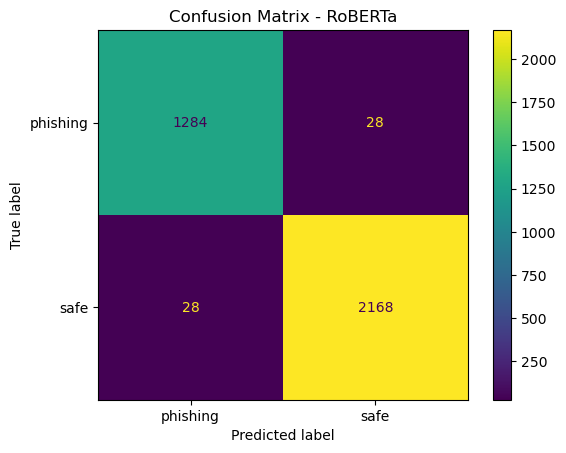

In [35]:
model.load_state_dict(torch.load("roberta-best.pt"))
model.eval()
preds, true_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true_labels += batch["labels"].cpu().tolist()

print("\n[RoBERTa] Test Results\n")
print("Accuracy :", accuracy_score(true_labels, preds))
print("F1 Score :", f1_score(true_labels, preds))
print("\nClassification Report:\n", classification_report(true_labels, preds, target_names=["phishing", "safe"]))

cm = confusion_matrix(true_labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["phishing", "safe"]).plot()
plt.title("Confusion Matrix - RoBERTa")
plt.show()
